## Leverage I: Buying the Market on Margin

In [27]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                          # To access websites.

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

Get historical market data from Kenneth French's [website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html):

In [15]:
z.namelist()

['F-F_Research_Data_Factors_daily.CSV']

In [16]:
crsp = pd.read_csv( z.open(z.namelist()[0]), skiprows=4, index_col=0) # this is what you get if you don't skip the last row...copyright notice.  if you dont skip the first 4 rows, you get an error.
crsp

,Mkt-RF,SMB,HML,RF
19260701,0.10,-0.24,-0.28,0.009
19260702,0.45,-0.32,-0.08,0.009
19260706,0.17,0.27,-0.35,0.009
19260707,0.09,-0.59,0.03,0.009
19260708,0.21,-0.36,0.15,0.009
...,...,...,...,...
20210223,-0.15,-1.28,0.90,0.000
20210224,1.15,1.20,1.34,0.000
20210225,-2.73,-1.12,0.87,0.000
20210226,-0.28,0.72,-1.56,0.000


In [17]:
url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
r = requests.get(url)                                                 # Get file
z = zipfile.ZipFile(io.BytesIO( r.content ))                          # Unzip file
crsp = pd.read_csv( z.open(z.namelist()[0]), skiprows=4, index_col=0)[:-1] / 100  #values are in percent, we want in decimal
crsp.index = pd.to_datetime(crsp.index)                               # Interpret index as dates
crsp

,Mkt-RF,SMB,HML,RF
1926-07-01,0.0010,-0.0024,-0.0028,0.00009
1926-07-02,0.0045,-0.0032,-0.0008,0.00009
1926-07-06,0.0017,0.0027,-0.0035,0.00009
1926-07-07,0.0009,-0.0059,0.0003,0.00009
1926-07-08,0.0021,-0.0036,0.0015,0.00009
...,...,...,...,...
2021-02-22,-0.0112,-0.0009,0.0314,0.00000
2021-02-23,-0.0015,-0.0128,0.0090,0.00000
2021-02-24,0.0115,0.0120,0.0134,0.00000
2021-02-25,-0.0273,-0.0112,0.0087,0.00000


Add risk-free rate to excess returns:

In [18]:
crsp['Mkt-RF'] + crsp['RF']

1926-07-01    0.00109
1926-07-02    0.00459
1926-07-06    0.00179
1926-07-07    0.00099
1926-07-08    0.00219
               ...   
2021-02-22   -0.01120
2021-02-23   -0.00150
2021-02-24    0.01150
2021-02-25   -0.02730
2021-02-26   -0.00280
Length: 24934, dtype: float64

In [19]:
crsp = (crsp['Mkt-RF'] + crsp['RF']).to_frame('CRSP')
crsp

,CRSP
1926-07-01,0.00109
1926-07-02,0.00459
1926-07-06,0.00179
1926-07-07,0.00099
1926-07-08,0.00219
...,...
2021-02-22,-0.01120
2021-02-23,-0.00150
2021-02-24,0.01150
2021-02-25,-0.02730


GET SPY and VTI (Vanguard Total Stock Market Index Fund) for comparison:

In [20]:
PRICE       = tiingo.get_dataframe(['SPY', 'VTI'],'1900-01-01', metric_name='adjClose')
PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)

RET = PRICE.pct_change()
RET[-3:]

,SPY,VTI
2021-03-25,0.005626,0.007372
2021-03-26,0.016115,0.016343
2021-03-29,-0.000505,-0.004698


CRSP index vs SPY:

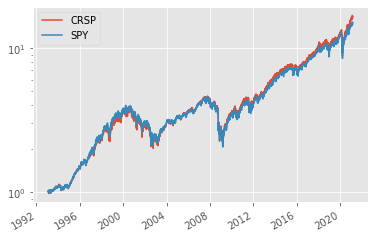

In [28]:
crsp.join(RET.SPY).dropna().add(1).cumprod().plot(logy=True)

CRSP index vs VTI:

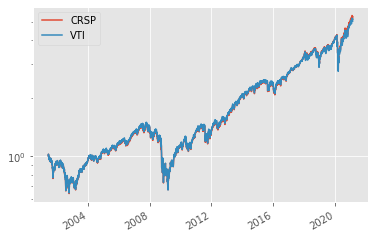

In [29]:
crsp.join(RET.VTI).dropna().add(1).cumprod().plot(logy=True)

Interactive Brokers [margin rates](https://www.interactivebrokers.com/en/accounts/fees/pricing-margin-rates.php)      
Get federal funds rate:

In [39]:
fedfunds = quandl.get(['FRED/FEDFUNDS']).rename(columns={'FRED/FEDFUNDS - Value':'Fedfunds'}) / 100 / 252
fedfunds

,Fedfunds
Date,
1954-07-01,0.000032
1954-08-01,0.000048
1954-09-01,0.000042
1954-10-01,0.000034
1954-11-01,0.000033
...,...
2020-10-01,0.000004
2020-11-01,0.000004
2020-12-01,0.000004


Merge CRSP and federal funds rate:

In [45]:
data = crsp.join(fedfunds, how = 'outer')
data['Fedfunds'] = data.Fedfunds.ffill()
data = data.dropna()
data

,CRSP,Fedfunds
1954-07-01,0.00022,0.000032
1954-07-02,0.00992,0.000032
1954-07-06,0.00862,0.000032
1954-07-07,0.00022,0.000032
1954-07-08,-0.00148,0.000032
...,...,...
2021-02-22,-0.01120,0.000003
2021-02-23,-0.00150,0.000003
2021-02-24,0.01150,0.000003
2021-02-25,-0.02730,0.000003


Assume margin rate equals fed funds rate + 100 basis points (1%):

In [47]:
data['MarginRate'] = data.Fedfunds + 0.01 / 252
data[-3:]

,CRSP,Fedfunds,MarginRate
2021-02-24,0.0115,0.000003,0.000043
2021-02-25,-0.0273,0.000003,0.000043
2021-02-26,-0.0028,0.000003,0.000043


Returns with leverage example:

account value: 100       
in stocks: 120       
cash: -20  (loan)      

Dollar tomorrow:
$$
120\times(1+r_\text{stocks}) - 20\times(1+r_\text{margin})
$$

Portfolio return:      
$$
\frac{120}{100}\times r_\text{stocks} - \frac{20}{100}\times r_\text{margin}
$$

150% leverage with daily rebalancing:

In [52]:
w = 1.5             # leverage ratio

t = pd.DataFrame()
t['CRSP']            = data.CRSP
t['Leverage']        = w * data.CRSP + (1-w) * data.MarginRate
t['Leverage_no_fee'] = w * data.CRSP + (1-w) * 0 
t['Loan']            = data.MarginRate

t.add(1).cumprod().iloc[-1]     # Show most recent values

CRSP                1052.382754
Leverage            2784.854016
Leverage_no_fee    18566.249141
Loan                  44.470921
Name: 2021-02-26 00:00:00, dtype: float64

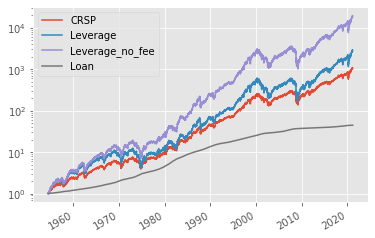

In [53]:
t.add(1).cumprod().plot(logy=True)

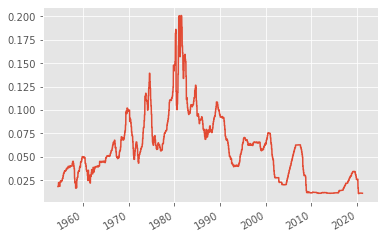

In [56]:
data.MarginRate.multiply(252).plot()

Leverage performance since 2010:

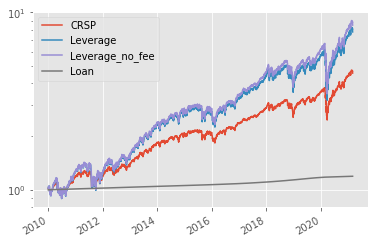

In [60]:
t['2010':].add(1).cumprod().plot(logy=True)

From January 2000 until September 2010:

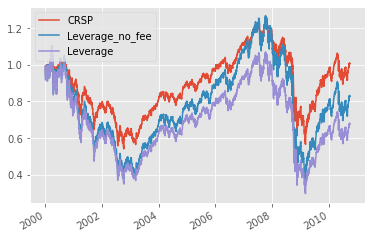

In [62]:
t['2000':'2010-9'][['CRSP','Leverage_no_fee', 'Leverage']].add(1).cumprod().plot()

Binomial example:

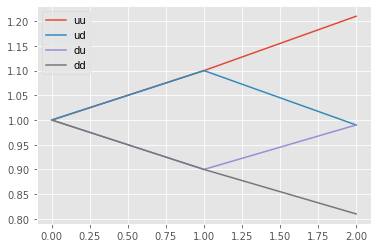

In [65]:
u = +0.1                  # Up factor
d = -0.1                 # Down factor

t = pd.DataFrame()
t['uu'] = [0,u,u]       # Twice up
t['ud'] = [0,u,d]       # First up, then down
t['du'] = [0,d,u]       # First down, then up
t['dd'] = [0,d,d]       # Twice down

t.add(1).cumprod().plot()

In [67]:
t.add(1).cumprod()

,uu,ud,du,dd
0,1.00,1.00,1.00,1.00
1,1.10,1.10,0.90,0.90
2,1.21,0.99,0.99,0.81


Suppose we use maximum leverage and we pay zero margin rate:

In [69]:
t.multiply(2).add(1).cumprod()

,uu,ud,du,dd
0,1.00,1.00,1.00,1.00
1,1.20,1.20,0.80,0.80
2,1.44,0.96,0.96,0.64


If we want the final value of the up-down and down-up paths to be equal to the starting value ($1):

In [72]:
u = +0.111111            # Up factor
d = -0.10            # Down factor

t = pd.DataFrame()
t['uu'] = [0,u,u]
t['ud'] = [0,u,d]
t['du'] = [0,d,u]
t['dd'] = [0,d,d]

t.add(1).cumprod()

,uu,ud,du,dd
0,1.000000,1.000000,1.0,1.00
1,1.111111,1.111111,0.9,0.90
2,1.234568,1.000000,1.0,0.81


With same leverage as above:

In [73]:
t.multiply(2).add(1).cumprod()

,uu,ud,du,dd
0,1.000000,1.000000,1.000000,1.00
1,1.222222,1.222222,0.800000,0.80
2,1.493827,0.977778,0.977778,0.64


Same time period, never rebalance:

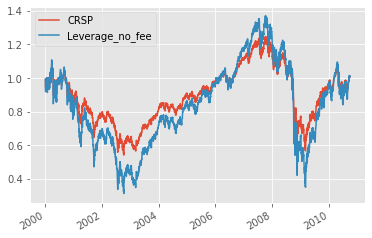

In [77]:
w = 1.5

t = pd.DataFrame()
t['CRSP']            = data['2000':'2010-9'].CRSP.add(1).cumprod()
t['Leverage_no_fee'] = w * data['2000':'2010-9'].CRSP.add(1).cumprod() + (1-w) * 1
t.plot()

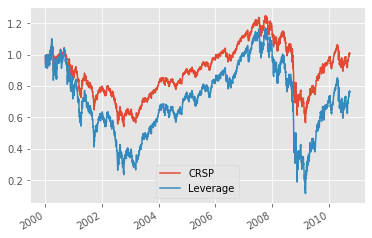

In [78]:
w = 1.5

t = pd.DataFrame()
t['CRSP']     = data['2000':'2010-9'].CRSP.add(1).cumprod()
t['Leverage'] = w * data['2000':'2010-9'].CRSP.add(1).cumprod() + (1-w) * data['2000':'2010-9'].MarginRate.add(1).cumprod()

t.plot()

### With rebalance loop

Let's use SPY returns:

In [ ]:
RET = RET.join(fedfunds)
RET['Fedfunds']   = RET.Fedfunds.ffill()
RET['MarginRate'] = RET.Fedfunds + 0.01/252
RET

In [ ]:
def get_rebalance_dates(frequency):
    group = getattr(PRICE.index, frequency) 
    return PRICE[:1].index.union(PRICE.groupby([PRICE.index.year, group]).tail(1).index)



def run_backtest(frequency):   

    weights = pd.Series({'SPY':1.5, 'MarginRate':-0.5})
    
    rebalance_dates = get_rebalance_dates(frequency)

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    leverage        = pd.Series(weights.SPY,              index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=weights.index, index=[rebalance_dates[0]])
    previous_positions = weights

    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        new_positions = portfolio_value.iloc[-1] * weights     

        start_to_end_positions = new_positions  * cum_ret

        portfolio_value = portfolio_value.append(start_to_end_positions.sum('columns'))                  
        leverage = leverage.append(start_to_end_positions.SPY / start_to_end_positions.sum('columns'))                  
                
        trades.loc[start_date]  = new_positions - previous_positions 
        previous_positions      = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value, leverage, trades


portfolio_value, leverage, trades = run_backtest('month')

In [ ]:
trades.cumsum().plot()

Dollar turnover:

In [ ]:
turnover = trades.abs().sum('columns').div(2)
turnover.plot()

Annual turnover ratio:

In [ ]:
turnover.resample('A').sum().div( portfolio_value.resample('A').mean() ).plot.bar()